In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import plotly.graph_objs as go

In [23]:
# replace the product categorie names to english
products = pd.read_csv('data/olist_products_dataset.csv')
products.rename(columns={'product_name_lenght': 'product_name_length',
                         'product_description_lenght': 'product_description_length'
                         }, inplace=True)  # just a typo correction
category_translation = pd.read_csv(
    'data/product_category_name_translation.csv')
products = pd.merge(products, category_translation, how="left",
                    on="product_category_name")
products.drop(["product_category_name"], axis=1, inplace=True)
products = products.rename(columns={"product_category_name_english":
                                    "product_category_name"})
o_items = pd.read_csv("data/olist_order_items_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
o_reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
geoloc = pd.read_csv("data/olist_geolocation_dataset.csv")
sellers = pd.read_csv("data/olist_sellers_dataset.csv")
o_payments = pd.read_csv("data/olist_order_payments_dataset.csv")
customers = pd.read_csv("data/olist_customers_dataset.csv")

olist = orders.merge(o_items, on='order_id', how='left')
olist = olist.merge(o_payments, on='order_id', how='outer', validate='m:m')
olist = olist.merge(o_reviews, on='order_id', how='outer')
olist = olist.merge(products, on='product_id', how='outer')
olist = olist.merge(customers, on='customer_id', how='outer')
olist = olist.merge(sellers, on='seller_id', how='outer')
olist.drop(['customer_id', 'order_purchase_timestamp', 'order_approved_at',
           'order_delivered_carrier_date', 'payment_sequential', 'review_id',
            'payment_type', 'payment_installments', 'review_id',
            'review_comment_title', 'review_comment_message', 'product_weight_g',
            'product_length_cm', 'product_height_cm', 'product_width_cm',
            'customer_unique_id', 'customer_zip_code_prefix',
            'customer_zip_code_prefix', 'customer_city', 'seller_zip_code_prefix',
            'seller_city', 'shipping_limit_date'], axis=1, inplace=True)

olist = olist.dropna()
olist.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 113209 entries, 0 to 119142
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113209 non-null  object 
 1   order_status                   113209 non-null  object 
 2   order_delivered_customer_date  113209 non-null  object 
 3   order_estimated_delivery_date  113209 non-null  object 
 4   order_item_id                  113209 non-null  float64
 5   product_id                     113209 non-null  object 
 6   seller_id                      113209 non-null  object 
 7   price                          113209 non-null  float64
 8   freight_value                  113209 non-null  float64
 9   payment_value                  113209 non-null  float64
 10  review_score                   113209 non-null  float64
 11  review_creation_date           113209 non-null  object 
 12  review_answer_timestamp       

In [24]:
olist

,order_id,order_status,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,price,freight_value,payment_value,review_score,review_creation_date,review_answer_timestamp,product_name_length,product_description_length,product_photos_qty,product_category_name,customer_state,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,18.12,4.0,2017-10-11 00:00:00,2017-10-12 03:43:48,40.0,268.0,4.0,housewares,SP,SP
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,2.00,4.0,2017-10-11 00:00:00,2017-10-12 03:43:48,40.0,268.0,4.0,housewares,SP,SP
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,18.59,4.0,2017-10-11 00:00:00,2017-10-12 03:43:48,40.0,268.0,4.0,housewares,SP,SP
3,128e10d95713541c87cd1a2e48201934,delivered,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,37.77,4.0,2017-08-19 00:00:00,2017-08-20 15:16:36,40.0,268.0,4.0,housewares,SP,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,delivered,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,37.77,5.0,2017-08-08 00:00:00,2017-08-08 23:26:23,40.0,268.0,4.0,housewares,SP,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119135,5bacbd9f42bd029c3a296501224e193e,delivered,2018-08-21 04:16:31,2018-08-30 00:00:00,2.0,710e8b076db06c8e5343a9e23f0e3d83,8dd386be0767c330276ea6a3f96532d3,44.99,22.25,134.48,5.0,2018-08-21 00:00:00,2018-08-21 22:01:55,60.0,645.0,2.0,sports_leisure,MG,SC
119138,1ab38815794efa43d269d62b98dae815,delivered,2018-07-09 15:06:57,2018-07-20 00:00:00,1.0,31ec3a565e06de4bdf9d2a511b822b4d,babcc0ab201e4c60188427cae51a5b8b,79.00,14.13,93.13,5.0,2018-07-10 00:00:00,2018-07-10 18:32:29,40.0,516.0,2.0,construction_tools_lights,SP,SP
119140,735dce2d574afe8eb87e80a3d6229c48,delivered,2018-08-02 22:47:35,2018-08-16 00:00:00,1.0,1d187e8e7a30417fda31e85679d96f0f,d263fa444c1504a75cbca5cc465f592a,399.00,45.07,444.07,5.0,2018-08-03 00:00:00,2018-08-04 11:22:40,43.0,729.0,2.0,furniture_decor,CE,SP
119141,25d2bfa43663a23586afd12f15b542e7,delivered,2018-06-12 23:11:29,2018-06-08 00:00:00,1.0,6e1c2008dea1929b9b6c27fa01381e90,edf3fabebcc20f7463cc9c53da932ea8,219.90,24.12,244.02,4.0,2018-06-10 00:00:00,2018-06-13 09:17:47,19.0,531.0,1.0,furniture_decor,MG,SP


In [25]:
olist.groupby("order_status").agg({"order_id": "nunique"}).\
sort_values('order_id', ascending=False)

,order_id
order_status,
delivered,94480
canceled,6


Sebagian dari pesanan tidak terkirim, jadi saya menghapusnya.

In [26]:
olist = olist[olist.order_status=='delivered']
olist = olist.drop(columns='order_status')

Mengeksplorasi data sedikit ...

Mata uang lokal (BRL atau R$ - disebut "reais") digunakan dalam kumpulan data.

<AxesSubplot:title={'center':'Average Revenue (R$) per Sale per Category'}, xlabel='product_category_name'>

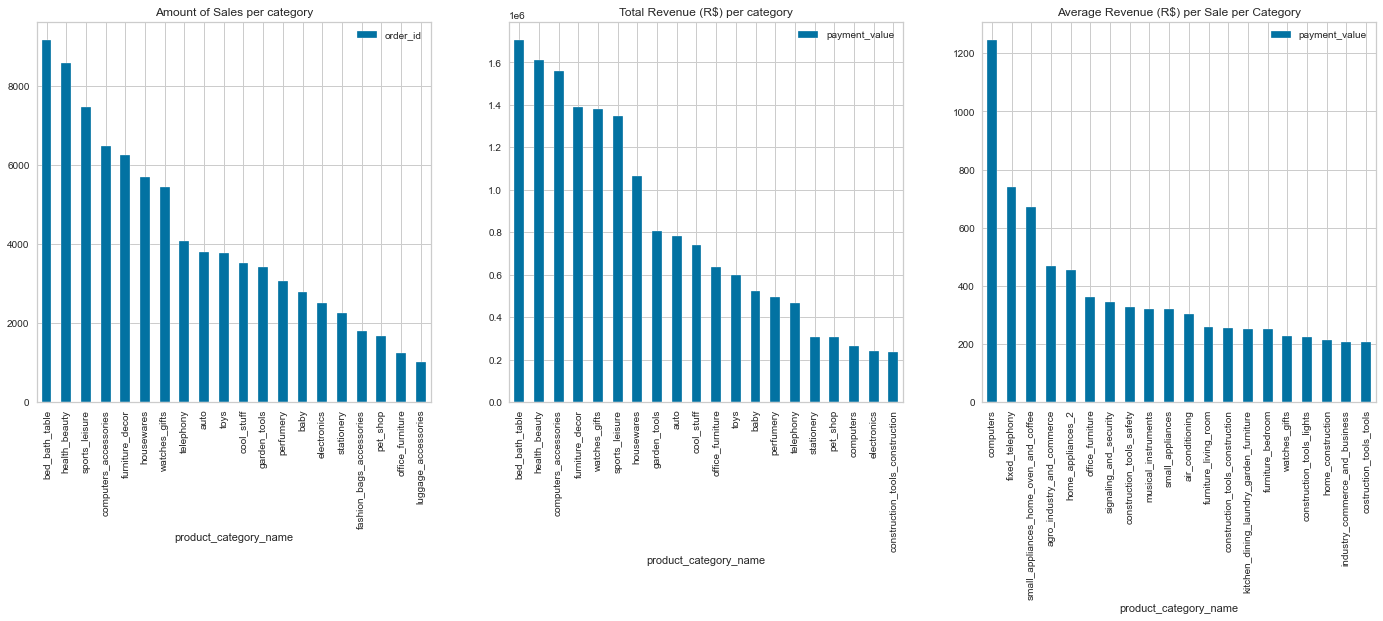

In [27]:
fig = plt.figure(figsize=(24, 7))

axes = plt.subplot2grid((1, 3), (0, 0))
olist.groupby("product_category_name").agg({"order_id": "nunique"})\
    .sort_values('order_id', ascending=False).head(20).plot.\
    bar(title='Amount of Sales per category', ax=axes)

axes = plt.subplot2grid((1, 3), (0, 1))
olist.groupby("product_category_name").agg({"payment_value": "sum"})\
    .sort_values('payment_value', ascending=False).head(20).plot.\
    bar(title='Total Revenue (R$) per category', ax=axes)

axes = plt.subplot2grid((1, 3), (0, 2))
olist.groupby("product_category_name").agg({"payment_value": "mean"})\
    .sort_values('payment_value', ascending=False).head(20).plot.\
    bar(title='Average Revenue (R$) per Sale per Category', ax=axes)


Sebagian besar produk yang dijual berada dalam kategori bed_bath_table, artinya produk seperti sprei, selimut, peralatan makan dari perak. Kategori ini juga merupakan pemimpin untuk total pendapatan. Kita dapat melihat bahwa kesehatan_kecantikan juga sangat penting. Pendapatan Rata-rata per Penjualan dipimpin oleh komputer.

Ada terlalu banyak kategori dalam kumpulan data untuk dipahami seseorang. Karena encoding (one hot encoding) diperlukan untuk menjalankan algoritme, saya hanya mempertimbangkan 10 kategori teratas untuk mengurangi jumlah kolom yang akan dibuat dalam kumpulan data.

(0.0, 37717.9)

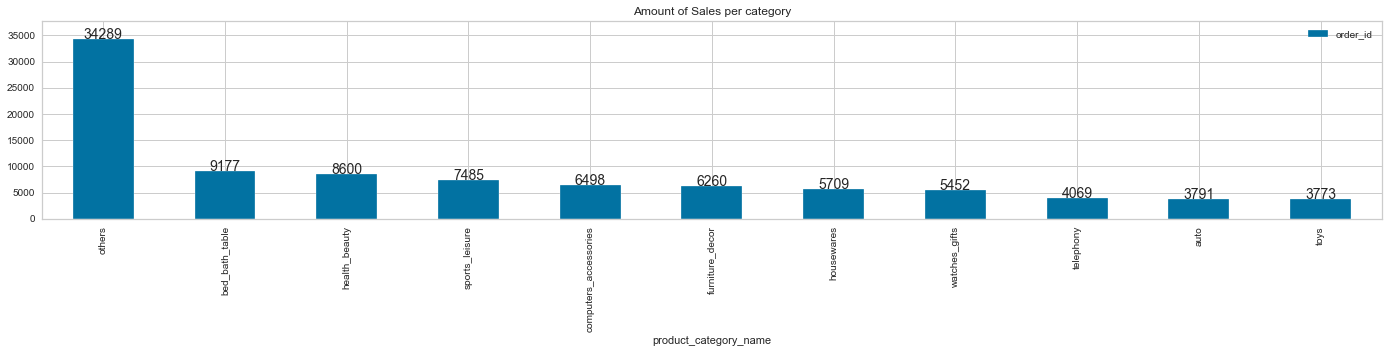

In [28]:
prod_cat_name = olist.groupby("product_category_name")\
    .agg({"order_id": "nunique"}).sort_values('order_id', ascending=False).index.\
    to_list()
outras_cat = list(
    (Counter(prod_cat_name)-Counter(prod_cat_name[0:10])).elements())
olist = olist.replace(outras_cat, 'others')

fig = plt.figure(figsize=(24, 8))

axes = plt.subplot2grid((2, 1), (0, 0))
olist.groupby("product_category_name").agg({"order_id": "nunique"})\
    .sort_values('order_id', ascending=False).plot.\
    bar(title='Amount of Sales per category', ax=axes)

sizes = []
for p in axes.patches:
    height = p.get_height()
    sizes.append(height)
    axes.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{}'.format(height),
              ha="center", fontsize=14)
axes.set_ylim(0, max(sizes) * 1.1)


(0.0, 4289.0)

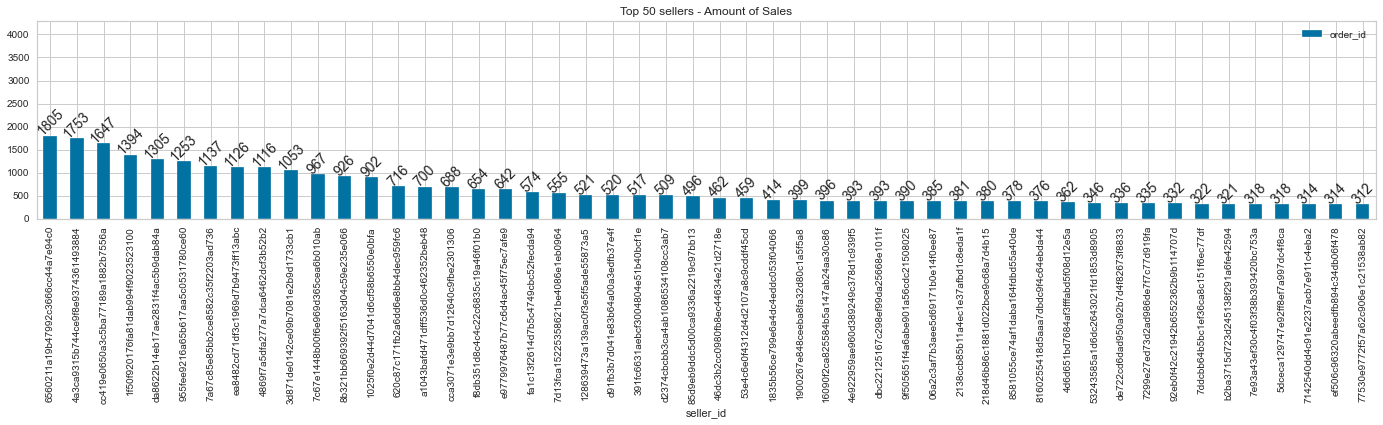

In [29]:
prod_cat_name = prod_cat_name[0:10]
prod_cat_name.append('others')
prod_cat_name.sort()
fig = plt.figure(figsize=(24, 8))
axes = plt.subplot2grid((2, 1), (1, 0))
olist.groupby("seller_id").agg({"order_id": "nunique"}).\
    sort_values('order_id', ascending=False).head(50).plot.bar(
    title='Top 50 sellers - Amount of Sales', ax=axes)
for p in axes.patches:
    height = p.get_height()
    sizes.append(height)
    axes.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{}'.format(height),
              ha="center", fontsize=14, 
              rotation=45)
axes.set_ylim(0, max(sizes) - 30000)

Kita dapat melihat di atas bahwa kita memiliki beberapa penjual yang sangat bagus. Salah satunya hampir mencapai penjualan 2k!


In [30]:
aux_seller = olist.groupby("seller_id").agg({"order_id": "nunique"}).\
sort_values('order_id', ascending=False)
N_totalsellers,aux = olist.groupby("seller_id").agg({"order_id": "nunique"}).\
sort_values('order_id', ascending=False).shape
N_uniquesell,aux = aux_seller[aux_seller.order_id==1].shape
print(f'Ada {round(((N_uniquesell)/N_totalsellers)*100,2)}% penjual dengan hanya satu penjualan.')

Ada 18.51% penjual dengan hanya satu penjualan.


Namun, ada banyak penjual satu penjualan juga.

In [31]:
olist['order_delivered_customer_date'] = pd.\
    to_datetime(olist.order_delivered_customer_date)
olist['order_estimated_delivery_date'] = pd.\
    to_datetime(olist.order_estimated_delivery_date)
olist['review_creation_date'] = pd.to_datetime(olist.review_creation_date)
olist['review_answer_timestamp'] = pd.to_datetime(
    olist.review_answer_timestamp)

olist['delivery_delay'] = olist.order_delivered_customer_date -\
    olist.order_estimated_delivery_date
olist['delivery_delay'] = olist.delivery_delay.astype('timedelta64[D]')
olist['delay_review_response'] = olist.review_answer_timestamp -\
    olist.review_creation_date
olist['delay_review_response'] = olist.delay_review_response.\
    astype('timedelta64[D]')

olist = olist.drop(columns=['order_delivered_customer_date',
                            'order_estimated_delivery_date',
                            'review_creation_date', 'review_answer_timestamp'])


(0.0, 73898.0)

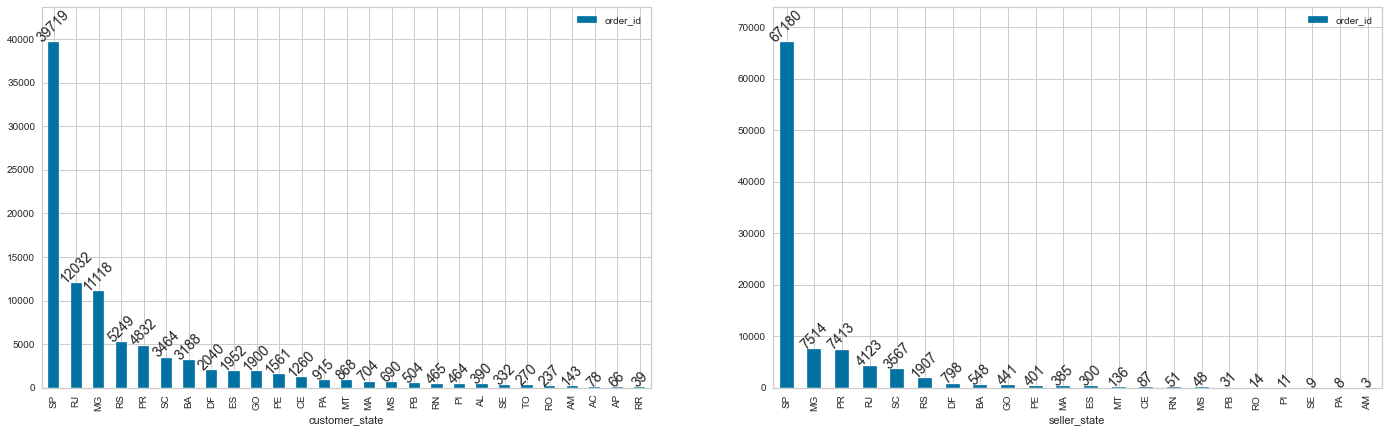

In [32]:
fig = plt.figure(figsize=(24, 7))
axes = plt.subplot2grid((1, 2), (0, 0))
olist.groupby('customer_state').agg({'order_id': 'nunique'}).sort_values(
    'order_id', ascending=False).plot.bar(ax=axes)
sizes = []
for p in axes.patches:
    height = p.get_height()
    sizes.append(height)
    axes.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{}'.format(height),
              ha="center", fontsize=14, rotation=45)
axes.set_ylim(0, max(sizes) * 1.1)

axes = plt.subplot2grid((1, 2), (0, 1))
olist.groupby('seller_state').agg({'order_id': 'nunique'}).sort_values(
    'order_id', ascending=False).plot.bar(ax=axes)
sizes = []
for p in axes.patches:
    height = p.get_height()
    sizes.append(height)
    axes.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{}'.format(height),
              ha="center", fontsize=14, rotation=45)
axes.set_ylim(0, max(sizes) * 1.1)


Bar plot di atas adalah distribusi geografis pelanggan dan penjual, per negara bagian Brasil. Ada 27 negara bagian di Brasil, tetapi kita dapat melihat bahwa transaksi didominasi oleh negara bagian tenggara, diikuti oleh negara bagian selatan. Daerah lain seperti utara, timur laut dan tengah-barat hampir tidak ada. Jadi saya mengumpulkan informasi ini dalam 3 kategori: Tenggara, Selatan dan Lainnya.

<AxesSubplot:title={'center':'Sellers by region'}, xlabel='seller_state'>

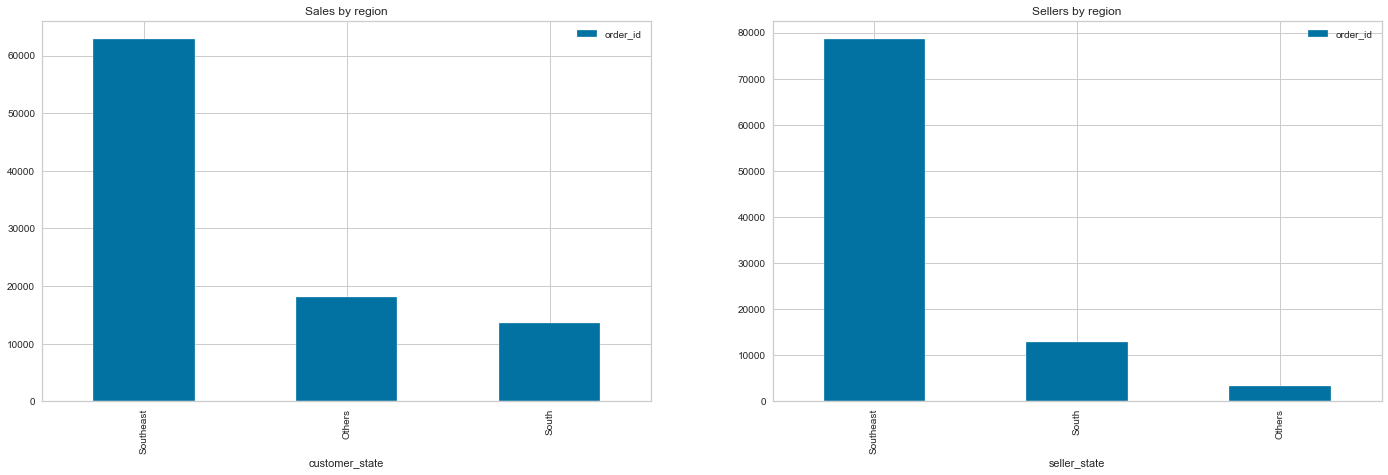

In [33]:
States = olist.groupby('customer_state').agg({'order_id':'nunique'})

Southeast = ['SP','RJ','MG']
South = ['RS','SC','PR']
Others = list((Counter(States.index)-Counter(Southeast)-Counter(South)).elements())

olist = olist.replace(Southeast,'Southeast')
olist = olist.replace(South,'South')
olist = olist.replace(Others,'Others')

fig = plt.figure(figsize=(24,7))

axes = plt.subplot2grid((1,2),(0,0))
olist.groupby('customer_state').agg({'order_id':'nunique'}).sort_values(
    'order_id', ascending=False).plot.bar(title = 'Sales by region',
                                          ax=axes)
axes = plt.subplot2grid((1,2),(0,1))
olist.groupby('seller_state').agg({'order_id':'nunique'}).sort_values(
    'order_id', ascending=False).plot.bar(title = 'Sellers by region',
                                          ax=axes)

Dominasi tenggara masih ada, tetapi seperti ini saya akan memiliki lebih sedikit kolom saat menerapkan One Hot Encoding.

Di bawah ini saya menerapkan pengkodean One Hot. Ini mengubah variabel kategori menjadi kolom yang hanya memiliki nol dan satu, jadi sesuatu yang numerik. Artinya, sesuatu yang dapat ditangani oleh Kmeans dan Hierarchical Clustering. Jadi, untuk setiap register yang mungkin dimiliki oleh variabel kategoris, sebuah kolom akan dibuat. "Satu" ditetapkan untuk kolom tertentu yang cocok dengan register dan 0 untuk yang lain.

In [34]:
enc = OneHotEncoder(sparse=False)


olist[['Cust_Others', 'Cust_South', 'Cust_Southeast']] = enc.fit_transform(
    olist[['customer_state']])
olist[['Sel_Others', 'Sel_South', 'Sel_Southeast']] = enc.fit_transform(
    olist[['seller_state']])
olist[prod_cat_name] = enc.fit_transform(olist[['product_category_name']])

olist_encoded = olist.drop(['customer_state', 'seller_state',
                            'product_category_name'], axis=1)


In [35]:
olist_encoded.tail(10)

,order_id,order_item_id,product_id,seller_id,price,freight_value,payment_value,review_score,product_name_length,product_description_length,...,bed_bath_table,computers_accessories,furniture_decor,health_beauty,housewares,others,sports_leisure,telephony,toys,watches_gifts
119128,8c1d27c10cc60cc369a428813bb71350,1.0,9680a78df870a1cb6ae00cb3436fe06a,a72f15980dc3e9bfd1a49ac9b2f3af65,89.90,18.73,108.63,4.0,50.0,1141.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119129,39e89b39b5cc8b5e3a38f23e915d1823,1.0,24fcd474105d95d2002f38f0cacf87ee,72c73be2b085b9d57650dd53eb2004c9,29.40,17.92,47.32,5.0,48.0,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119131,fbff77db5421bb7e1da292db45d07e75,1.0,654ccc4e5459e7ba6b8d9fb04c45b9db,2d8cfba3fcd3170555941605edaa196a,45.00,10.96,8.25,5.0,45.0,1403.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
119132,fbff77db5421bb7e1da292db45d07e75,1.0,654ccc4e5459e7ba6b8d9fb04c45b9db,2d8cfba3fcd3170555941605edaa196a,45.00,10.96,47.71,5.0,45.0,1403.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
119134,5bacbd9f42bd029c3a296501224e193e,1.0,710e8b076db06c8e5343a9e23f0e3d83,8dd386be0767c330276ea6a3f96532d3,44.99,22.25,134.48,5.0,60.0,645.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
119135,5bacbd9f42bd029c3a296501224e193e,2.0,710e8b076db06c8e5343a9e23f0e3d83,8dd386be0767c330276ea6a3f96532d3,44.99,22.25,134.48,5.0,60.0,645.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
119138,1ab38815794efa43d269d62b98dae815,1.0,31ec3a565e06de4bdf9d2a511b822b4d,babcc0ab201e4c60188427cae51a5b8b,79.00,14.13,93.13,5.0,40.0,516.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
119140,735dce2d574afe8eb87e80a3d6229c48,1.0,1d187e8e7a30417fda31e85679d96f0f,d263fa444c1504a75cbca5cc465f592a,399.00,45.07,444.07,5.0,43.0,729.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119141,25d2bfa43663a23586afd12f15b542e7,1.0,6e1c2008dea1929b9b6c27fa01381e90,edf3fabebcc20f7463cc9c53da932ea8,219.90,24.12,244.02,4.0,19.0,531.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119142,1565f22aa9452ff278638e87cc895678,1.0,9c1e194db1d35a79d962ea610bfe0868,f3862c2188522d89860c38a3ea8b550d,15.50,12.79,28.29,5.0,40.0,871.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Sejauh ini, saya pada dasarnya menggabungkan informasi order. Sekarang, saya perlu menggabungkan data ini untuk penjual. Saya melakukan ini menggunakan groupby di bawah ini. Untuk beberapa variabel, agregasi dilakukan dalam nilai rata-rata, yang lain nilai maksimum, yang lain jumlah. Saya mencoba menggunakan apa yang paling masuk akal bagi saya, tetapi ada banyak cara lain untuk melakukannya.

In [36]:
data = olist_encoded.groupby('seller_id').agg({'order_id': 'nunique',
                                               'product_id': 'nunique',
                                               'payment_value': 'mean',
                                               'review_score': 'mean',
                                               'product_name_length': 'mean',
                                               'product_description_length': 'mean',
                                               'product_photos_qty': 'mean',
                                               'delivery_delay': 'mean',
                                               'delay_review_response': 'mean',
                                               'Cust_Others': 'sum',
                                               'Cust_Southeast': 'sum',
                                               'Cust_South': 'sum',
                                               'Sel_Others': 'max',
                                               'Sel_Southeast': 'max',
                                               'Sel_South': 'max',
                                               'auto': 'sum',
                                               'bed_bath_table': 'sum',
                                               'computers_accessories': 'sum',
                                               'furniture_decor': 'sum',
                                               'health_beauty': 'sum',
                                               'housewares': 'sum',
                                               'others': 'sum',
                                               'sports_leisure': 'sum',
                                               'telephony': 'sum',
                                               'toys': 'sum',
                                               'watches_gifts': 'sum',
                                               })
data


,order_id,product_id,payment_value,review_score,product_name_length,product_description_length,product_photos_qty,delivery_delay,delay_review_response,Cust_Others,...,bed_bath_table,computers_accessories,furniture_decor,health_beauty,housewares,others,sports_leisure,telephony,toys,watches_gifts
seller_id,,,,,,,,,,,,,,,,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,3,1,916.020000,3.666667,40.000000,849.000000,2.000000,-16.333333,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
001cca7ae9ae17fb1caed9dfb1094831,192,11,202.367811,3.974249,35.828326,471.974249,1.789700,-13.566524,2.150215,47.0,...,0.0,0.0,0.0,0.0,0.0,233.0,0.0,0.0,0.0,0.0
002100f778ceb8431b7a1020ff7ab48f,50,24,42.160862,4.086207,55.189655,654.689655,1.000000,-8.517241,1.655172,9.0,...,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
004c9cd9d87a3c30c522c48c4fc07416,143,78,154.792303,4.175758,56.236364,530.296970,1.054545,-11.909091,2.327273,30.0,...,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00720abe85ba0859807595bbf045a33b,13,9,119.938462,3.653846,43.576923,493.192308,2.230769,-12.730769,0.884615,4.0,...,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffc470761de7d0232558ba5e786e57b7,27,15,74.454062,4.281250,54.968750,835.937500,1.531250,-11.781250,1.593750,8.0,...,0.0,0.0,1.0,0.0,10.0,13.0,1.0,0.0,0.0,6.0
ffdd9f82b9a447f6f8d4b91554cc7dd3,18,12,171.786667,4.285714,49.428571,517.095238,1.190476,-12.238095,2.380952,0.0,...,0.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0
ffeee66ac5d5a62fe688b9d26f83f534,14,3,161.396429,4.214286,55.357143,801.285714,4.928571,-8.357143,1.785714,3.0,...,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0


Sebelum menjalankan algoritma clustering, saya memeriksa korelasi antar variabel. Jika dua atau lebih variabel berkorelasi terlalu kuat, mereka pada dasarnya tidak membawa informasi baru untuk mendefinisikan cluster. Oleh karena itu, replika dapat di hapus untuk mengurangi beban komputasi.

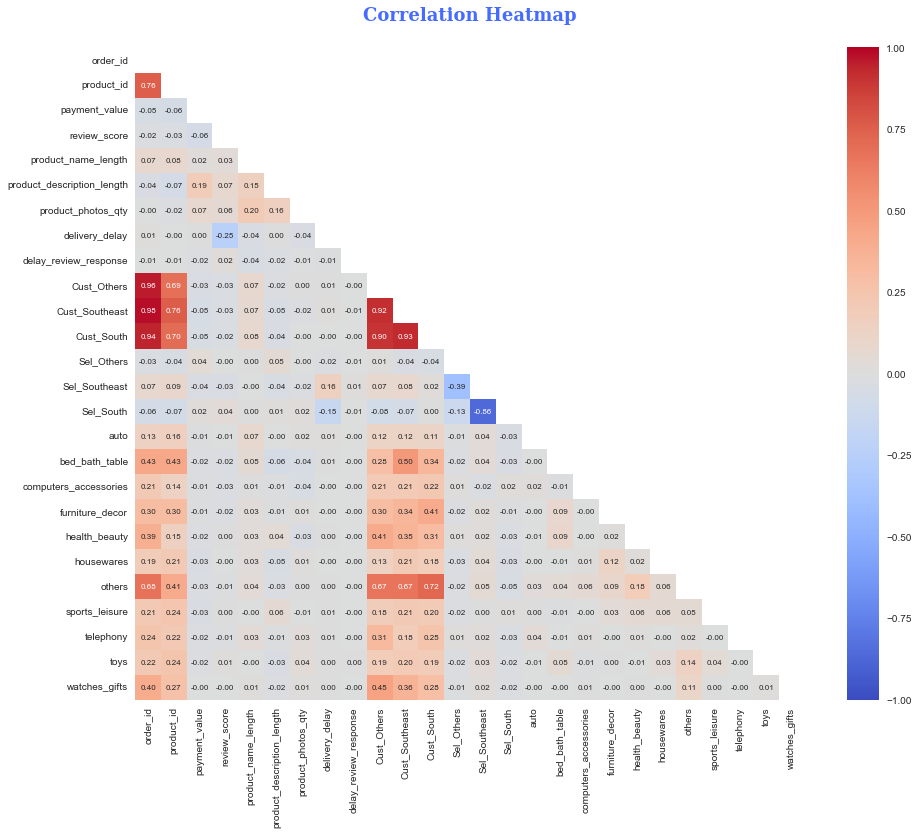

In [37]:
sns.set_style("whitegrid")
font_title = {"family": "serif",
              "color":  "#476bff",
              "weight": "bold",
              "size": 18}

corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15, 12))
ax = sns.heatmap(corr, annot=True,
                 vmin=-1, vmax=1,
                 fmt=".2f", annot_kws={'size': 8},
                 mask=mask,
                 center=0,
                 cmap="coolwarm")
plt.title(f"Correlation Heatmap\n",
          fontdict=font_title)
plt.show()



Ada korelasi yang kuat antara jumlah penjualan yang dilakukan penjual dan jumlah produk yang ditawarkan. Saya akan menghapus yang terakhir.

Juga, ada korelasi yang kuat antara variabel wilayah pelanggan dan wilayah penjual. Saya akan menghapus yang pertama.

In [38]:
data = data.drop(columns=['product_id', 'Cust_Others', 'Cust_Southeast',
                          'Cust_South'])


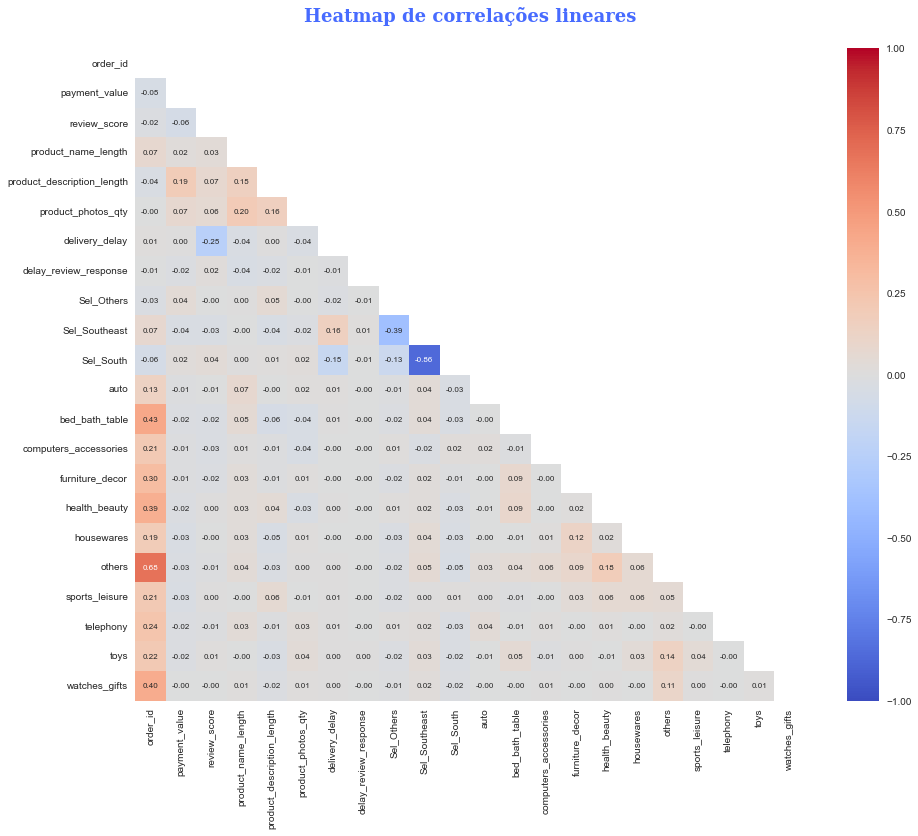

In [39]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15, 12))
ax = sns.heatmap(corr, annot=True,
                 vmin=-1, vmax=1,
                 fmt=".2f", annot_kws={'size': 8},
                 mask=mask,
                 center=0,
                 cmap="coolwarm")
plt.title(f"Heatmap de correlações lineares\n",
          fontdict=font_title)
plt.show()


terlihat bagus dengan peta korelasi sekarang. Mari kita beralih ke penerapan algoritma clustering.

In [40]:
data

,order_id,payment_value,review_score,product_name_length,product_description_length,product_photos_qty,delivery_delay,delay_review_response,Sel_Others,Sel_Southeast,...,bed_bath_table,computers_accessories,furniture_decor,health_beauty,housewares,others,sports_leisure,telephony,toys,watches_gifts
seller_id,,,,,,,,,,,,,,,,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,3,916.020000,3.666667,40.000000,849.000000,2.000000,-16.333333,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
001cca7ae9ae17fb1caed9dfb1094831,192,202.367811,3.974249,35.828326,471.974249,1.789700,-13.566524,2.150215,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,233.0,0.0,0.0,0.0,0.0
002100f778ceb8431b7a1020ff7ab48f,50,42.160862,4.086207,55.189655,654.689655,1.000000,-8.517241,1.655172,0.0,1.0,...,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
004c9cd9d87a3c30c522c48c4fc07416,143,154.792303,4.175758,56.236364,530.296970,1.054545,-11.909091,2.327273,0.0,1.0,...,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00720abe85ba0859807595bbf045a33b,13,119.938462,3.653846,43.576923,493.192308,2.230769,-12.730769,0.884615,0.0,1.0,...,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffc470761de7d0232558ba5e786e57b7,27,74.454062,4.281250,54.968750,835.937500,1.531250,-11.781250,1.593750,0.0,1.0,...,0.0,0.0,1.0,0.0,10.0,13.0,1.0,0.0,0.0,6.0
ffdd9f82b9a447f6f8d4b91554cc7dd3,18,171.786667,4.285714,49.428571,517.095238,1.190476,-12.238095,2.380952,0.0,0.0,...,0.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0
ffeee66ac5d5a62fe688b9d26f83f534,14,161.396429,4.214286,55.357143,801.285714,4.928571,-8.357143,1.785714,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0


K-means Clustering
Saya menulis sebuah fungsi untuk Kmeans. Ia melakukan hal-hal berikut:

1. Ini memroses dataset menggunakan MinMaxScaler.
2. Ini memplot kurva siku untuk metode distorsi secara otomatis memilih jumlah cluster yang optimal
3. Ini memplot kurva siku untuk metode Silhouette dan Calinski_Harabasz untuk validasi
4. Ini memplot koefisien siluet untuk semua sampel
5. Ini memplot jarak cluster
6. Ini menjalankan algoritma Kmeans untuk jumlah cluster optimal yang ditentukan oleh metode distorsi
7. Ini mengembalikan dataset dengan kolom baru dengan label cluster
Catatan:

Kurva siku dengan metode distorsi adalah plot dengan jumlah jarak kuadrat, atau distorsi, pada sumbu y dan jumlah cluster pada sumbu x. Kurva ini akan selalu berkurang, karena distorsi akan menjadi nol jika jumlah cluster sama dengan jumlah register dalam dataset (singleton - cluster dengan hanya satu register). Menariknya, plot ini selalu memiliki titik belok, di mana distorsinya turun dengan cepat dan penurunannya perlahan. Titik tersebut merupakan jumlah cluster yang optimal.

Kurva siku menggunakan Silhouette dan Calinski_Harabasz berbeda dari distorsi. Pada tipe ini, kita mencari maksimum untuk menentukan jumlah cluster yang optimal.

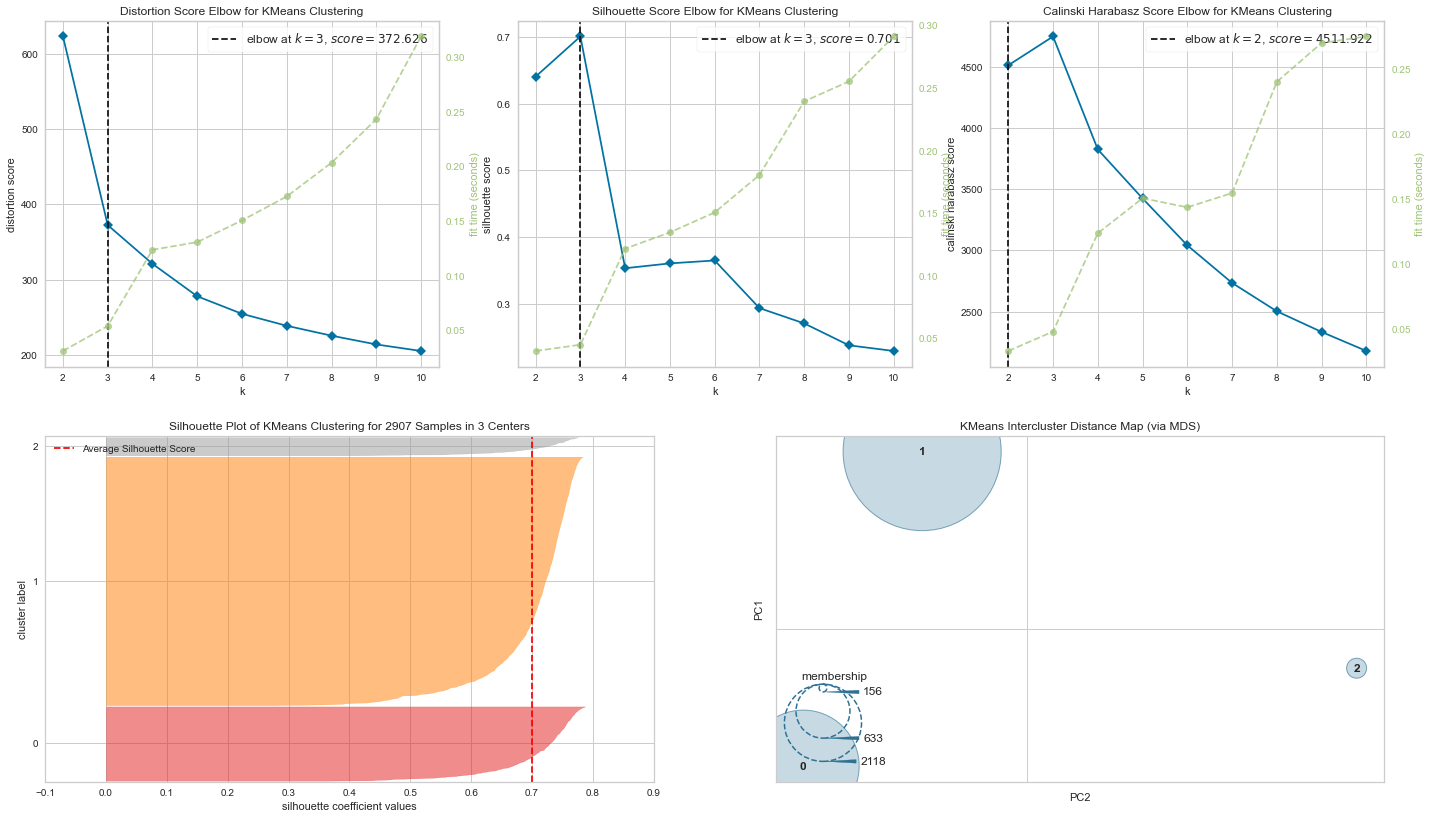

In [43]:
scaler = MinMaxScaler()


def Kmeansplots(data):
    X = data.copy()
    numerical_features = list(data.select_dtypes(include=['int64', 'float64',
                                                          'uint8']).columns)
    preprocessor = ColumnTransformer([
        ('scaler', scaler, numerical_features)])

    plt.figure(figsize=(24, 14))
    ax1 = plt.subplot(2, 3, 1)
    ax2 = plt.subplot(2, 3, 2)
    ax3 = plt.subplot(2, 3, 3)
    ax4 = plt.subplot(2, 2, 3)
    ax5 = plt.subplot(2, 2, 4)

    visual_grid1 = [
        (Pipeline([("preprocessor", preprocessor), ("kelbowvisualizer", KElbowVisualizer(KMeans(), K=(4, 12), metric='distortion',
                                                                                         ax=ax1))]), 'kelbowvisualizer'),
        (Pipeline([("preprocessor", preprocessor), ("kelbowvisualizer", KElbowVisualizer(KMeans(), K=(4, 12), metric='silhouette',
                                                                                         ax=ax2))]), 'kelbowvisualizer'),
        (Pipeline([("preprocessor", preprocessor), ("kelbowvisualizer", KElbowVisualizer(KMeans(), K=(4, 12), metric='calinski_harabasz',
                                                                                         ax=ax3))]), 'kelbowvisualizer')
    ]

    i = 0
    for viz in visual_grid1:
        viz[0].fit(X)
        if i == 0:
            # Defining the best K by distortion method
            K = viz[0].named_steps['kelbowvisualizer'].elbow_value_
            i = i+1
        viz[0].named_steps[viz[1]].finalize()

    visual_grid2 = [(Pipeline([("preprocessor", preprocessor), ("silhouettevisualizer",
                                                                SilhouetteVisualizer(KMeans(K, random_state=0), ax=ax4))]),
                     'silhouettevisualizer'),
                    (Pipeline([("preprocessor", preprocessor), ("distancevisualizer",
                                                                InterclusterDistance(KMeans(K, random_state=0), ax=ax5))]),
                     'distancevisualizer')]
    for viz in visual_grid2:
        viz[0].fit(X)
        viz[0].named_steps[viz[1]].finalize()

    # KMeans Pipeline with best K
    kmeans_model = Pipeline([("preprocessor", preprocessor),
                            ("kmeans", KMeans(K, random_state=0))])
    kmeans_model.fit(X)
    # Kmeans labels
    kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
    X["kmeans_label"] = kmeans_labels

    return X


X_0 = Kmeansplots(data)


Metode 3 elbow mendefinisikan jumlah optimal cluster sebagai 3. Plot Silhouette menunjukkan koefisien siluet yang tinggi untuk semua register, yang berarti bahwa cluster padat. Dengan plot interdistance, terbukti bahwa cluster berjauhan satu sama lain.

In [ ]:
X_0.groupby(['kmeans_label']).agg({'kmeans_label':'count',  
                                   'Sel_Others':'sum',
                                   'Sel_Southeast':'sum',
                                   'Sel_South':'sum'})

,kmeans_label,Sel_Others,Sel_Southeast,Sel_South
kmeans_label,,,,
0,633,0.0,0.0,633.0
1,2118,0.0,2118.0,0.0
2,156,156.0,0.0,0.0


Masalahnya adalah bahwa cluster pada dasarnya ditentukan oleh wilayah penjual, seperti yang terlihat pada hasil pengelompokan di atas. Jadi tidak ada informasi yang berguna. Karena itu, saya menghapus kolom dataset dan melakukan analisis sekali lagi.

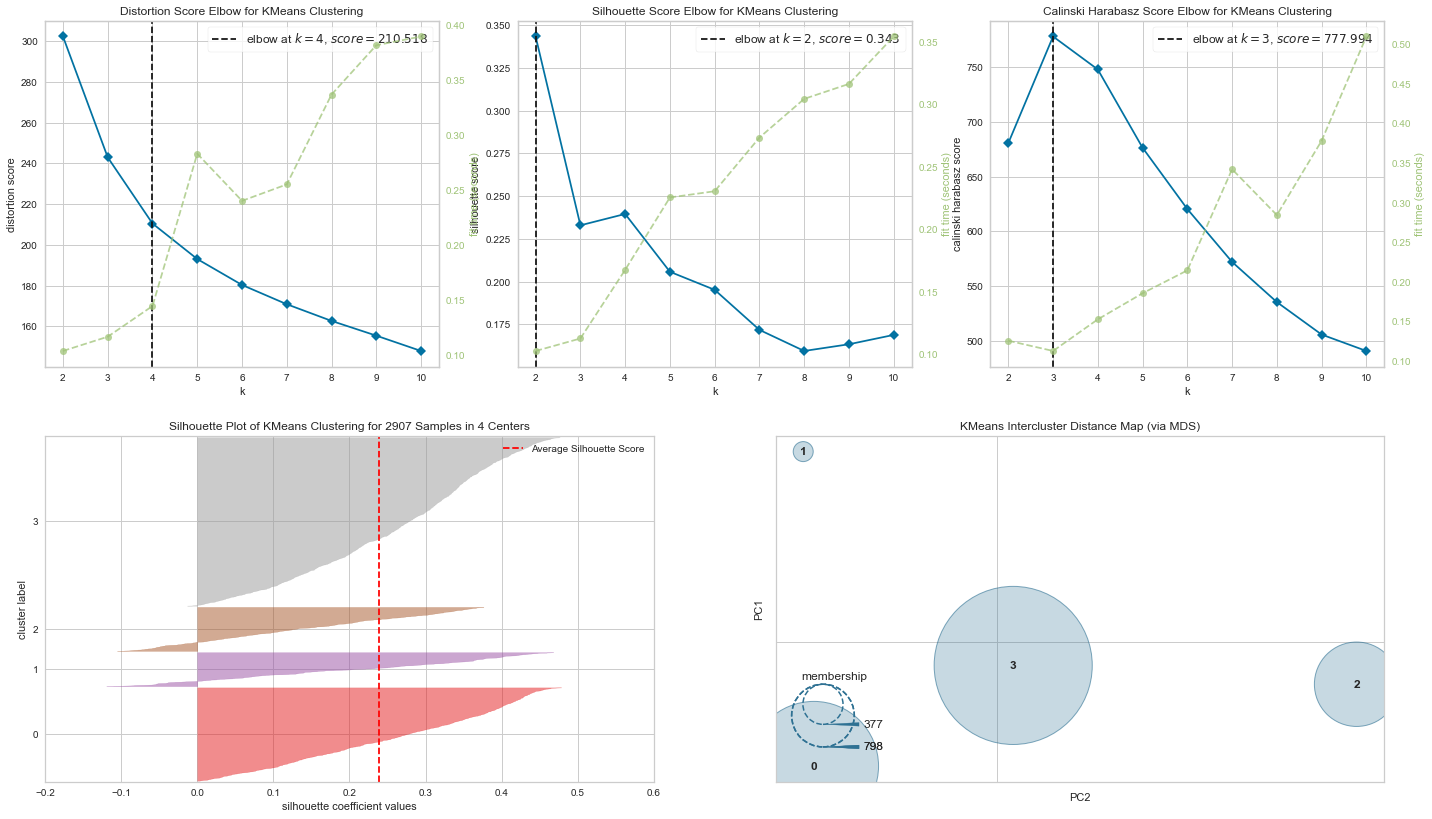

In [45]:
data_1 = data.drop(columns=['Sel_Others','Sel_South','Sel_Southeast'])
#data_1.to_csv(path+'seller_data_1.csv')
X_1= Kmeansplots(data_1)

Kurva siku dengan metode distorsi didapatkan 4 cluster. Ini berbeda untuk lekukan siku dengan siluet dan Calinski Harabasz. Tapi, untuk Silhouette, meskipun nilai tertinggi adalah 2 cluster, 4 adalah maksimum lokal dan untuk Calinski Harabasz 4 adalah pilihan terbaik kedua. Jadi saya memutuskan untuk tetap dengan 4 cluster.

Plot Silhouettte menunjukkan nilai negatif untuk beberapa register di cluster 0, 1 dan 2, yang bukan hasil terbaik. Juga, Koefisien Siluet Rata-rata rendah. Itu adalah 0,7 solid ketika wilayah geografis penjual dipertimbangkan tetapi itu tidak berguna.

Plot Intercluster Distance menunjukkan pelanggan berada pada jarak yang baik satu sama lain.

In [46]:
X_1.groupby('kmeans_label').agg({'order_id':'count'})

,order_id
kmeans_label,
0,798
1,291
2,377
3,1441


Kelompok terbesar adalah cluster 3 diikuti oleh cluster 0. Di bawah ini saya memeriksa data dari segi kategori produk.

<AxesSubplot:title={'center':'Median Number of Sales per Category per Cluster'}, xlabel='kmeans_label'>

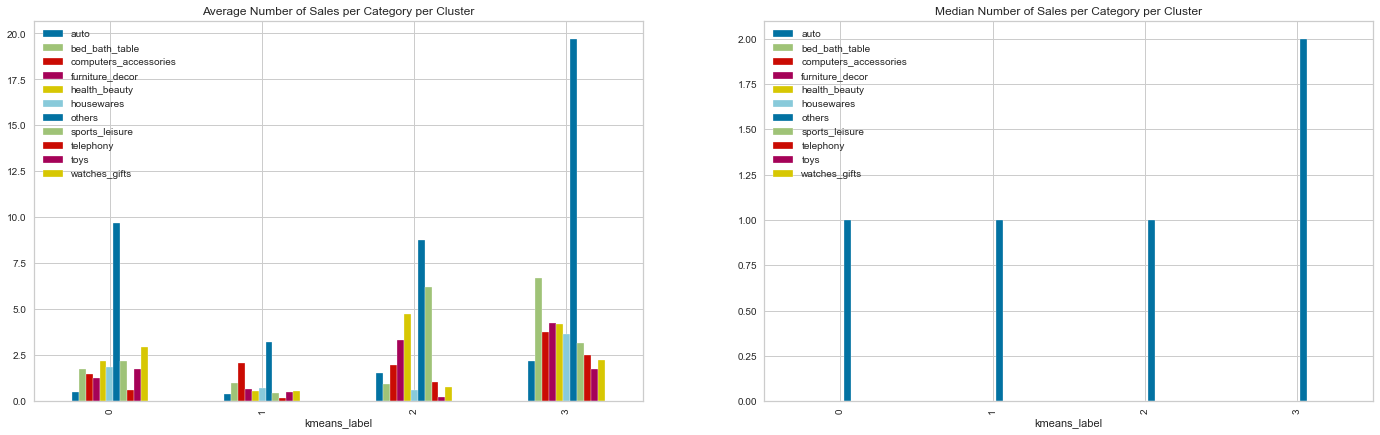

In [47]:
fig = plt.figure(figsize=(24, 7))

axes = plt.subplot2grid((1, 2), (0, 0))
X_1.groupby(['kmeans_label']).agg({'auto': 'mean',
                                   'bed_bath_table': 'mean',
                                   'computers_accessories': 'mean',
                                   'furniture_decor': 'mean',
                                   'health_beauty': 'mean',
                                   'housewares': 'mean',
                                   'others': 'mean',
                                   'sports_leisure': 'mean',
                                   'telephony': 'mean',
                                   'toys': 'mean',
                                   'watches_gifts': 'mean',
                                   }).plot.bar(ax=axes,
                                               title='Average Number of Sales per Category per Cluster')
axes = plt.subplot2grid((1, 2), (0, 1))
X_1.groupby(['kmeans_label']).agg({'auto': 'median',
                                   'bed_bath_table': 'median',
                                   'computers_accessories': 'median',
                                   'furniture_decor': 'median',
                                   'health_beauty': 'median',
                                   'housewares': 'median',
                                   'others': 'median',
                                   'sports_leisure': 'median',
                                   'telephony': 'median',
                                   'toys': 'median',
                                   'watches_gifts': 'median',
                                   }).plot.bar(ax=axes,
                                               title='Median Number of Sales per Category per Cluster')


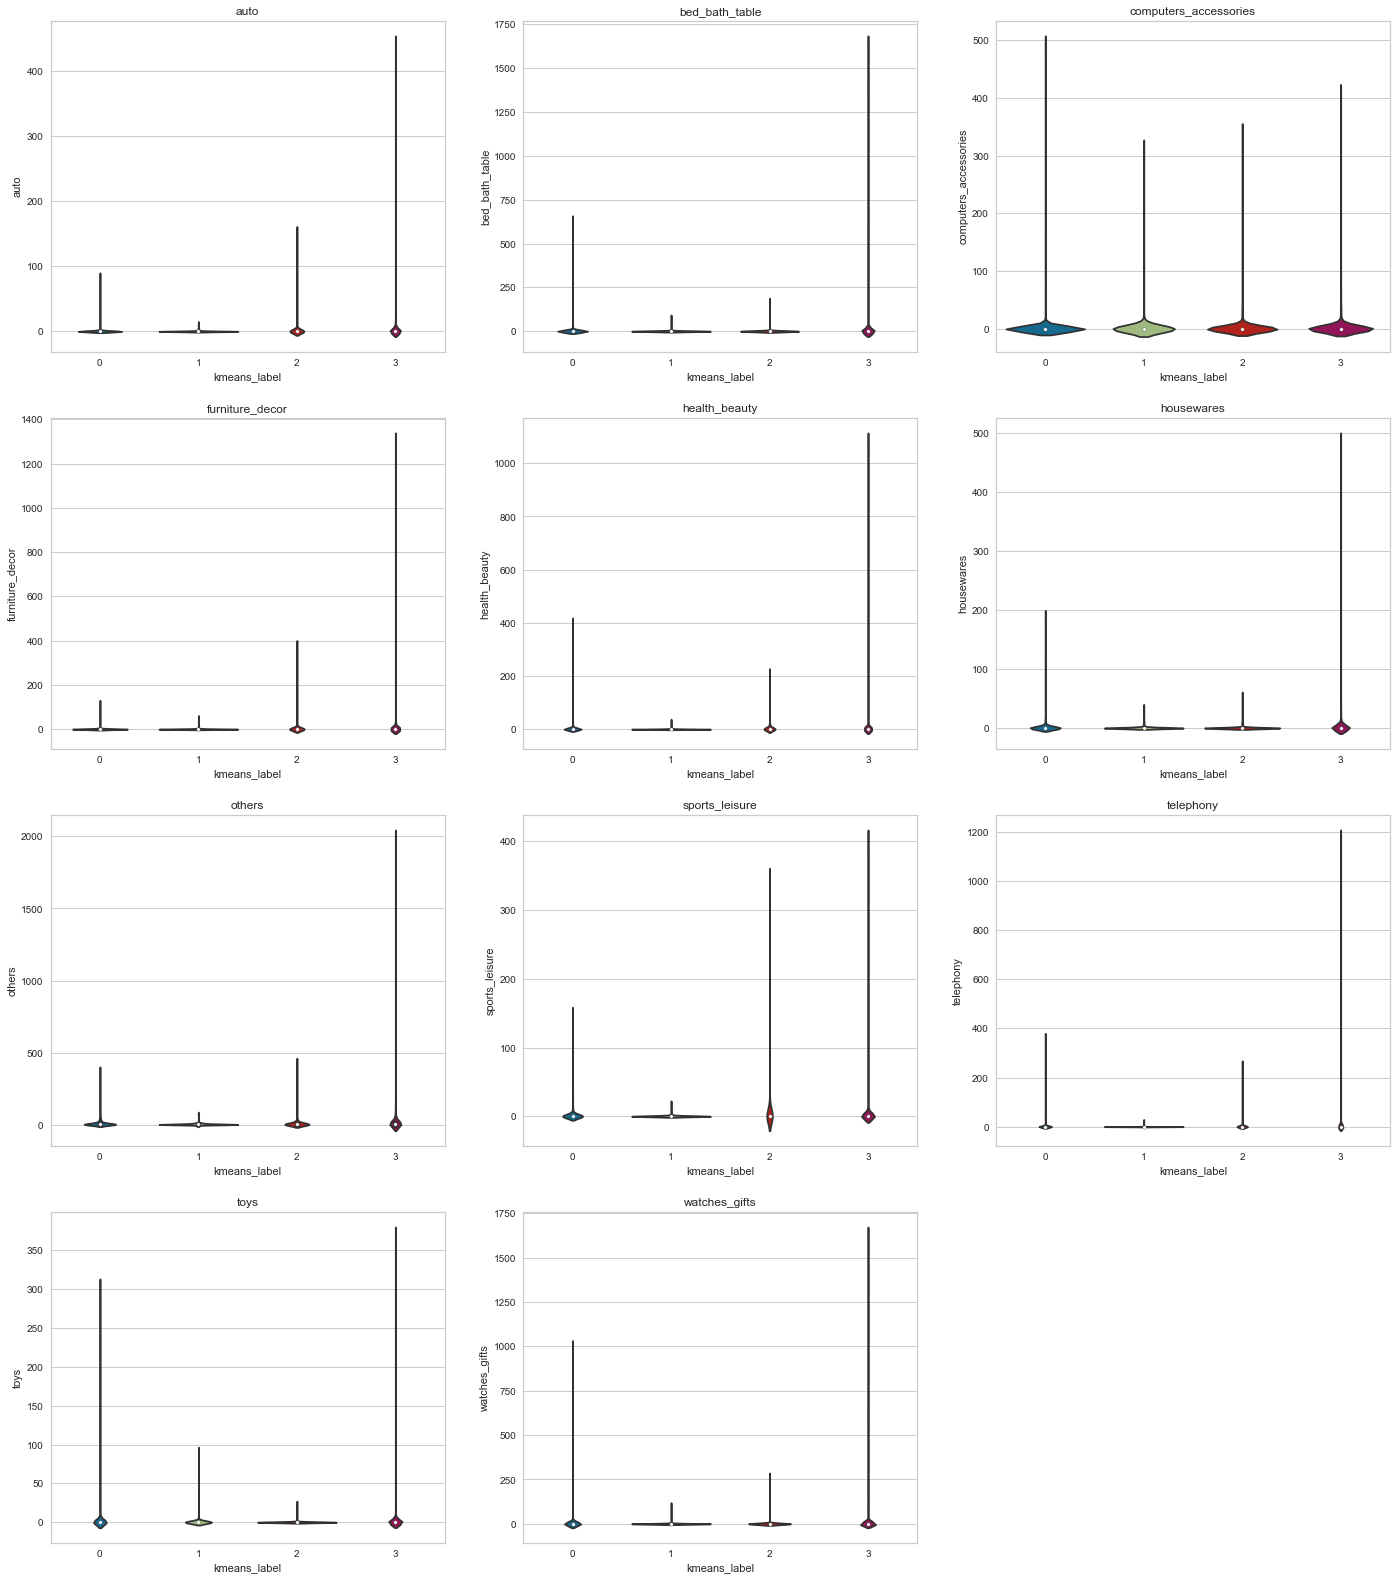

In [48]:
aux = X_1.columns
fig = plt.figure(figsize=(24, 28))
a = 0
b = 0
for i in aux[8:19]:
    axes = plt.subplot2grid((4, 3), (a, b))
    sns.violinplot(x=X_1['kmeans_label'], y=X_1[i], ax=axes)
    axes.set_title(i)
    axes.yaxis.grid(True)
    axes.set_xlabel('kmeans_label')
    b = b+1
    if b >= 3:
        b = 0
        a = a+1


Plot batang di atas adalah rata-rata dan median jumlah penjualan per kategori per cluster. Ternyata, tidak ada kesesuaian antara cluster dan kategori produk. Dalam rata-rata penjualan, setiap kategori muncul di setiap cluster dan jumlah rata-rata penjualan adalah nol untuk setiap kategori di setiap cluster kecuali untuk kategori "lain-lain". Artinya, setidaknya 50% penjual di setiap cluster tidak melakukan penjualan di kategori tersebut. Ini semua dikuatkan oleh plot biola. Semua biola tebal pada dasarnya dan hampir membentuk garis lurus saat naik, yang berarti bahwa sebagian besar poin tidak menghasilkan penjualan tunggal pada kategori tersebut.

Oleh karena itu, saya memutuskan untuk menghapus kolom ini dari kumpulan data yang terlihat menarik. Jadi, saya membuat data_1_reduced dataset dan menjalankan fungsi kmeans sekali lagi.

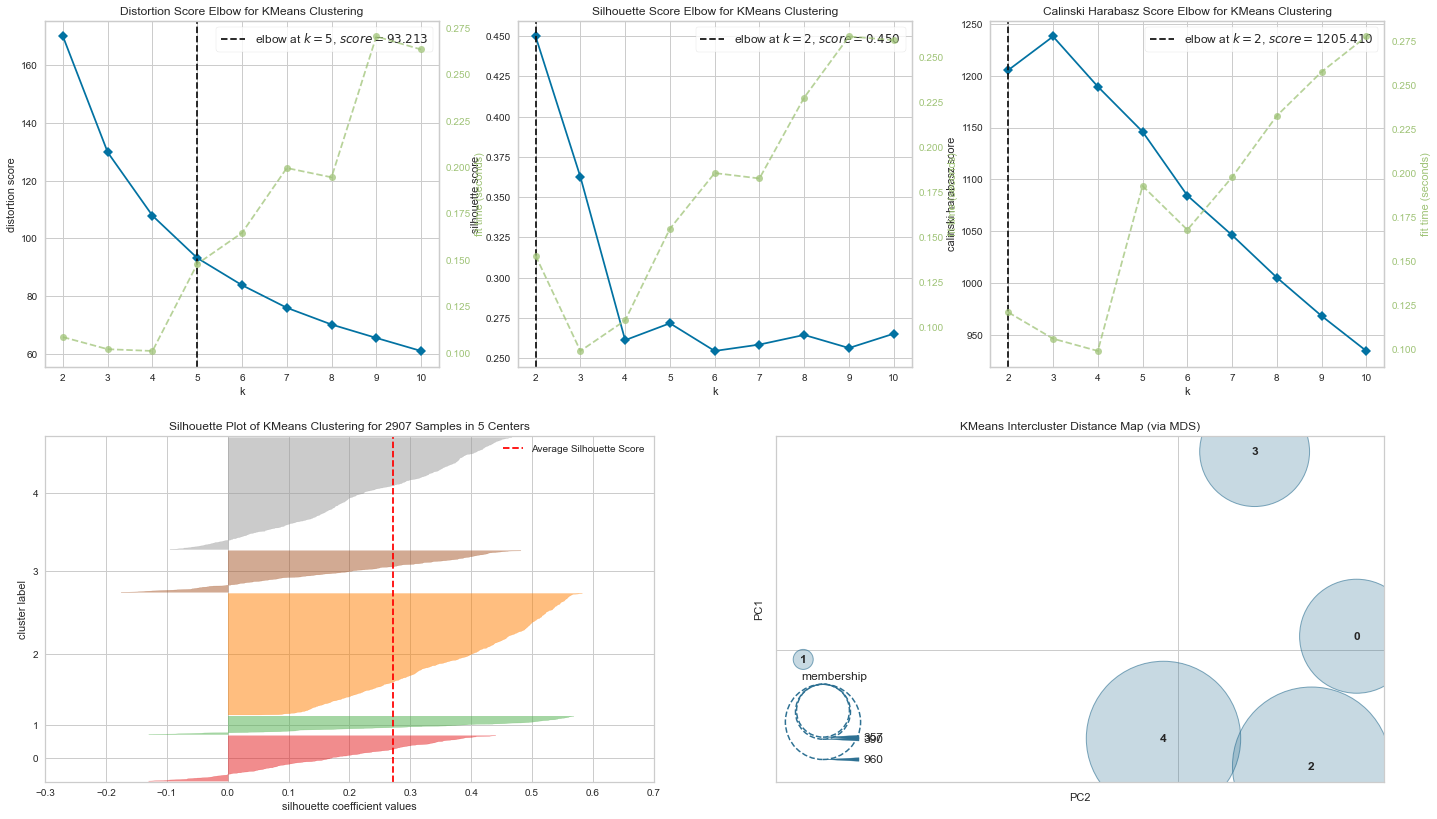

In [49]:
data_1_reduced = data_1[['order_id','payment_value','review_score',
                        'product_description_length','product_photos_qty',
                         'delivery_delay']]

X_1_reduced= Kmeansplots(data_1_reduced)

Sekarang saya mendapat 5 cluster, bukan 3 dan 4 sebelumnya.

In [50]:
X_1_reduced.groupby('kmeans_label').agg({'order_id': ['count', 'median'],
                                         'payment_value': 'median',
                                         'review_score': 'median',
                                         'product_description_length': 'median',
                                         'product_photos_qty': 'median',
                                         'delivery_delay': 'median'
                                         })


order_id        payment_value review_score  \
                count median        median       median   
kmeans_label                                              
0                 390    7.5    149.344150     4.447088   
1                 158    2.0    165.870000     1.816667   
2                1042    5.0    119.570985     4.666667   
3                 357    6.0    160.140923     4.466667   
4                 960   11.5    139.879038     3.875000   

             product_description_length product_photos_qty delivery_delay  
                                 median             median         median  
kmeans_label                                                               
0                            812.000000           4.393727     -12.669697  
1                            609.910714           1.100962      -8.916667  
2                            617.321429           1.500000     -12.437690  
3                           1925.000000           2.000000     -12.285714  
4                            589.945021           1.662281     -11.657810

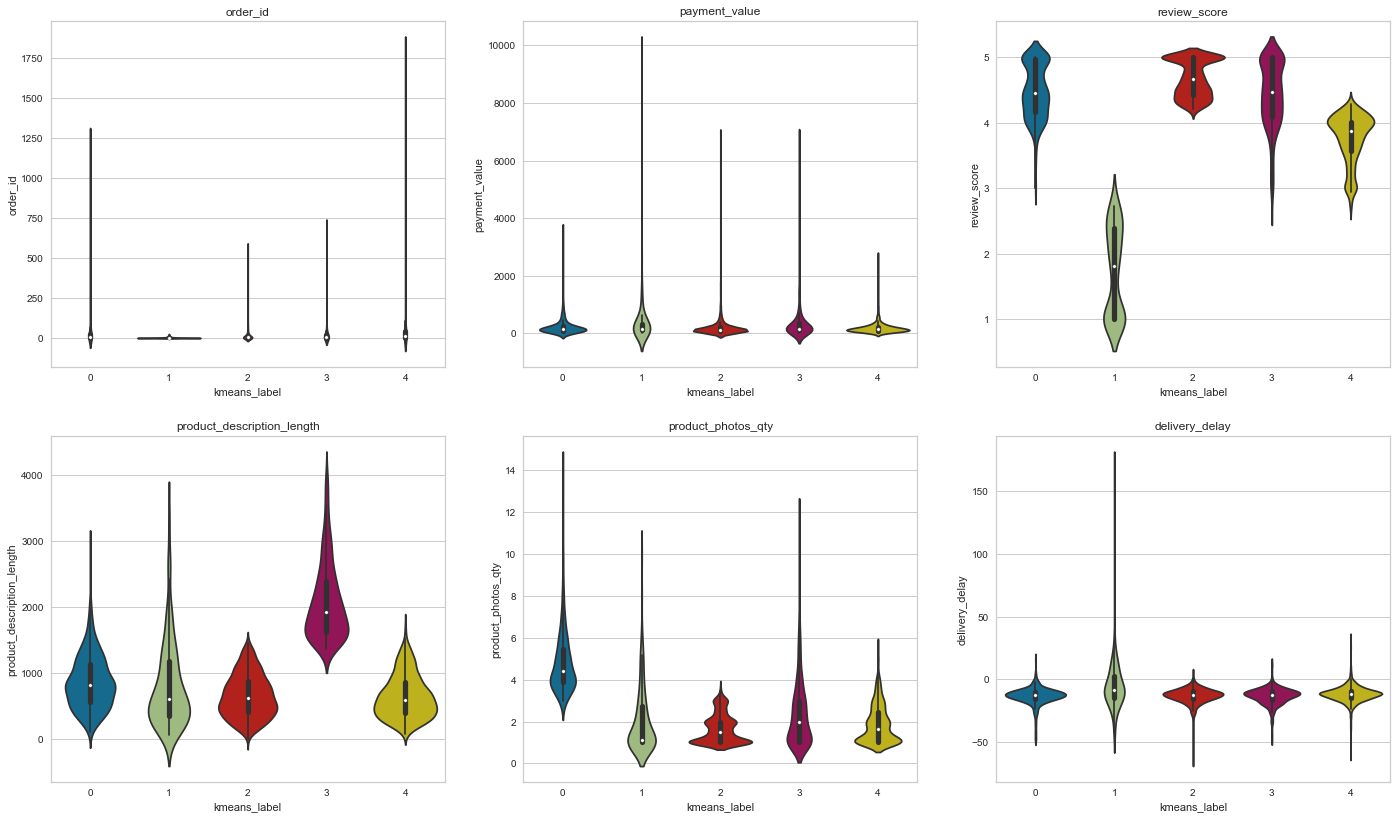

In [51]:
n_plot = 231
fig = plt.figure(figsize=(24, 14))
for i in X_1_reduced.columns:
    if i != 'kmeans_label':
        axes = fig.add_subplot(n_plot)
        sns.violinplot(x=X_1_reduced['kmeans_label'],
                       y=X_1_reduced[i], ax=axes)
        axes.set_title(i)
        axes.yaxis.grid(True)
        axes.set_xlabel('kmeans_label')
        n_plot = n_plot+1


Kelompok 0:
Kelompok ini sangat mirip dengan kelompok 3, tetapi mereka menempatkan lebih banyak gambar dan teks kecil untuk menggambarkan produk mereka.

Kelompok 1:
Ini adalah cluster dengan anggota paling sedikit. Pada dasarnya, apa yang membedakan mereka adalah bahwa mereka menerima ulasan buruk dari pelanggan mereka dan itu, sebagian, dijelaskan oleh keterlambatan pengiriman. Sebagian besar penjual ini tidak berhasil mengirimkan produk mereka tepat waktu. Mereka menjual paling sedikit. Mungkin, dapat disimpulkan bahwa cluster ini mengumpulkan penjual online non-profesional. Orang yang hanya perlu menjual satu barang sekali dan tidak perlu melakukannya lagi.

Kelompok 2:
Ini adalah cluster dengan anggota paling banyak. Sebagian besar dari mereka melakukan beberapa penjualan dan menerima nilai pembayaran terkecil (dengan pengecualian). Mereka menerima skor ulasan tertinggi dari klien mereka. Sepertinya mereka tidak terlalu memaksakan diri dalam mendeskripsikan produk mereka, karena memiliki panjang deskripsi paling rendah dan gambar paling sedikit. Produk mereka dikirim tepat waktu.

Kelompok 3:
Anggota cluster ini menjual sedikit lebih banyak daripada yang ada di cluster 0, mereka mengirimkan tepat waktu dan memiliki ulasan yang baik. Ciri yang jelas adalah mendeskripsikan produknya dengan banyak teks dan tidak terlalu banyak gambar.

Kelompok 4:
Ini adalah kelompok terbesar kedua. Juara penjualan ada di cluster ini, tetapi Anda dapat menemukan anggota yang tidak menjual sebanyak itu. Mereka tidak berusaha keras dalam menggambarkan produk mereka, produk mereka dikirimkan tepat waktu, tetapi mereka tidak menerima evaluasi yang baik seperti yang diterima oleh cluster 0.

# Hierarchical Clustering


Pertama-tama, saya menerapkan dendogram ke data_1_reduced dataset. Dibutuhkan waktu lebih lama dari kluster Kmeans untuk menghitung, jadi saya tidak repot-repot mencoba ini untuk data atau data_1 karena itu akan memakan waktu lebih lama lagi.

Seperti yang Anda lihat, saya tidak menerapkan praprosesor apa pun.

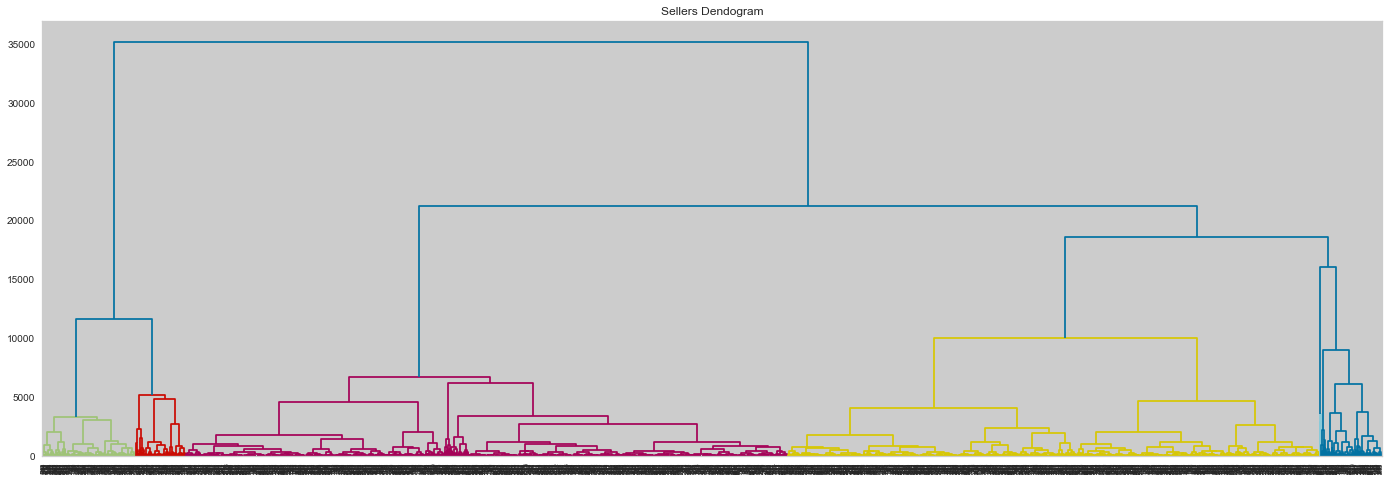

In [52]:
plt.figure(figsize=(24, 8))  
plt.title("Sellers Dendogram")
link = shc.linkage(data_1_reduced, method='ward',metric='euclidean')
dend = shc.dendrogram(link, color_threshold=11000)  

Saya menetapkan ambang 11000 berdasarkan firasat, dengan memeriksa dendrogram secara visual. Hasilnya, saya mendapat 6 cluster. Dua dari mereka sangat besar dalam anggota dan satu sangat kecil.

In [53]:
X_hier = data_1_reduced.copy()
cluster = AgglomerativeClustering(
    n_clusters=6, affinity='euclidean', linkage='ward')
agrup = cluster.fit_predict(X_hier)
X_hier['labels'] = agrup
X_hier.groupby('labels').agg({'order_id': ['count', 'median'],
                              'payment_value': 'median',
                              'review_score': 'median',
                              'product_description_length': 'median',
                              'product_photos_qty': 'median',
                              'delivery_delay': 'median'
                              })


order_id        payment_value review_score product_description_length  \
          count median        median       median                     median   
labels                                                                         
0          1154      8    147.019981     4.297872                 926.500000   
1           131      5   1013.700000     4.250000                1099.228261   
2          1308      7    111.645000     4.235983                 425.410428   
3           108      4    193.150750     4.500000                2718.953846   
4             3      1   6929.310000     5.000000                1748.266667   
5           203      6    161.370000     4.352941                1841.551724   

       product_photos_qty delivery_delay  
                   median         median  
labels                                    
0                1.989130     -12.000000  
1                2.307692     -13.000000  
2                1.666667     -12.000000  
3                2.000000     -12.000000  
4                2.000000      -6.266667  
5                2.000000     -11.909091

Jadi, saya sampai pada kesimpulan bahwa cluster 4, kelompok terkecil, terdiri dari outlier. Yang membedakan mereka adalah mereka berhasil menjual secara online, pada kesempatan langka, produk dengan harga sangat tinggi, jauh lebih tinggi dari kerumunan produk lainnya. Kelompok besar, kelompok 0 dan 2, serupa tetapi kelompok pertama menggambarkan produk dengan lebih rinci, menjadi median panjang deskripsi dua kali lebih panjang dari kelompok kedua. Median foto juga lebih tinggi.

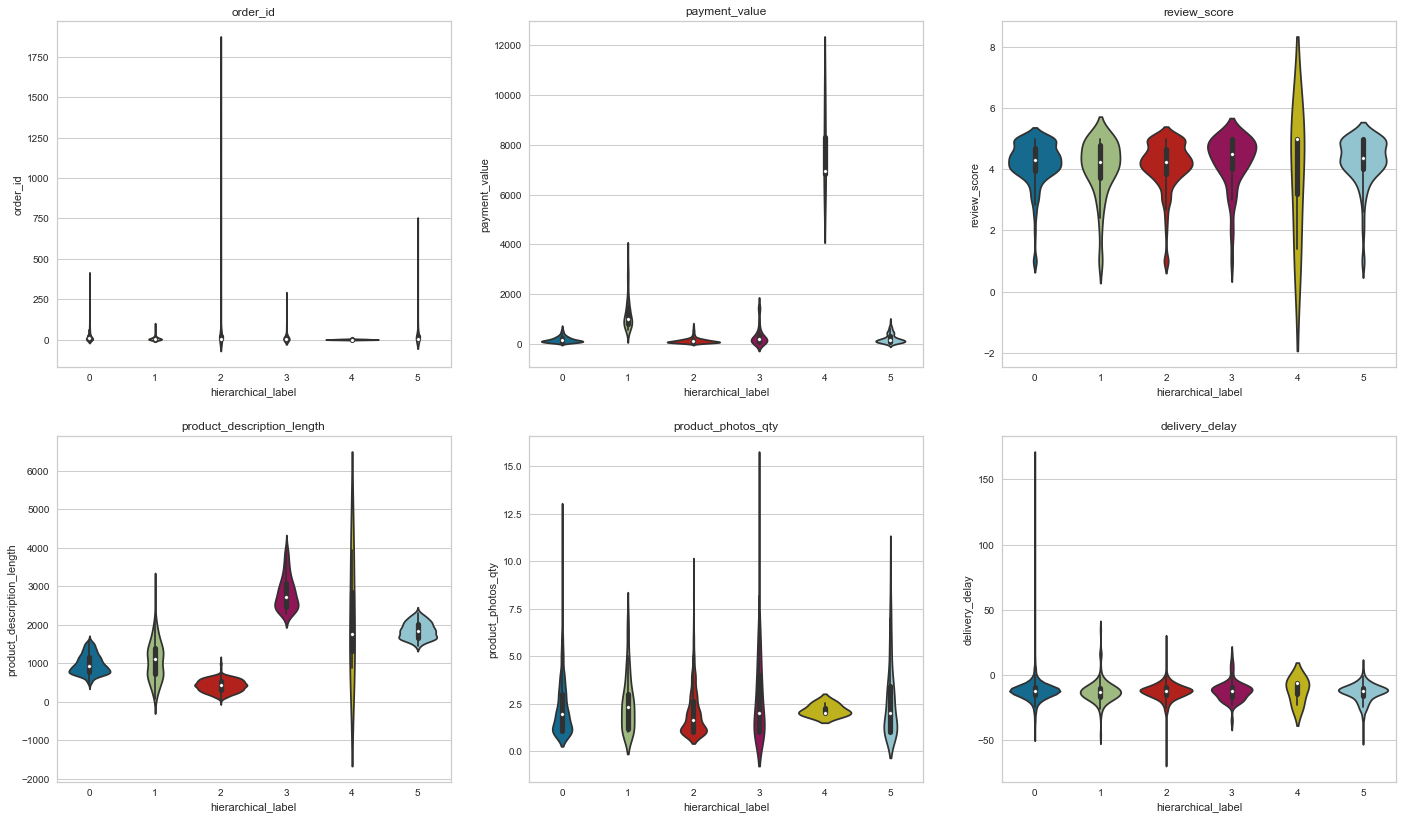

In [54]:
n_plot = 231
fig = plt.figure(figsize=(24, 14))
for i in X_hier:
    if i != 'labels':
        axes = fig.add_subplot(n_plot)
        sns.violinplot(x=X_hier['labels'], y=X_hier[i], ax=axes)
        axes.set_title(i)
        axes.yaxis.grid(True)
        axes.set_xlabel('hierarchical_label')
        n_plot = n_plot+1


Kelompok 0:
Ini adalah cluster terbesar kedua, cluster 2 menjadi yang terbesar. Mereka berdua menjual produk dengan harga murah, menerima ulasan yang sama dari pelanggan, dan hampir selalu mengirimkannya tanpa penundaan. Cluster 0 menggunakan lebih banyak teks untuk mendeskripsikan produk mereka. Mereka menggunakan lebih banyak foto daripada cluster 2 tetapi perbedaannya lebih halus.

Kelompok 1:
Klaster 1 pada dasarnya menjual produk dengan harga lebih tinggi dari yang lain. Tentu saja, mereka tidak semahal yang dijual oleh cluster 4. Jumlah penjualannya tidak seekspresif kelompok lain, tetapi ada anggota yang menghasilkan lebih dari 100 penjualan. Mereka menggambarkan produk mereka dengan teks yang mirip dengan cluster 0, bahkan mungkin teks yang lebih panjang, dan memposting lebih banyak gambar.

Kelompok 2:
Ini adalah kelompok terbesar. Mereka menjual produk dengan harga rendah, sebagian besar dikirimkan tepat waktu dan menerima ulasan yang hampir sama dengan kluster 0. Mereka mendeskripsikan produk mereka dengan teks yang jauh lebih sedikit, separuh sepanjang kluster 0, dan lebih sedikit gambar. Dalam kelompok ini terdapat penjual yang paling banyak menjual produk.

Kelompok 3:
Cluster 3 berisi penjual yang menjual produk dengan harga rendah dan beberapa dari mereka (sangat sedikit) menjual produk dalam jumlah yang baik. Mereka menggunakan teks terpanjang dari semua cluster untuk menggambarkan produk mereka.

Kelompok 4:
Ini adalah grup terkecil, hanya berisi 3 penjual. Mereka adalah outlier dalam dataset. Apa yang membedakan mereka adalah harga yang sangat tinggi dari produk mereka. Mereka menjual dalam jumlah kecil.

Kelompok 5:
Ini adalah klaster yang mirip dengan klaster 3: produk harga rendah; beberapa anggota menjual produk dalam jumlah yang baik; tidak ada yang perlu diperhatikan tentang skor ulasan atau keterlambatan pengiriman. Mereka tidak menggunakan banyak teks seperti cluster 3, meskipun deskripsi mereka lebih panjang dari cluster 0 dan 2.

Kesimpulan
Marketplace adalah tempat pembeli dan penjual berharap untuk menemukan satu sama lain secara online untuk melakukan transaksi. Tidak hanya pembeli yang dibutuhkan. Produk perlu ditawarkan secara efektif. Oleh karena itu, penting untuk mengenal penjual lebih baik untuk memahami mereka.

Saya melakukan analisis klaster yang diterapkan pada kumpulan data penjualan online. Tujuan dari analisis adalah penjual dan bukan pembeli. Dua metode diterapkan: K-means dan Hierarchical Clustering.

Dengan bantuan visualisator Yellowbrick, K-means sangat mudah digunakan. Sayangnya, data dari lokasi penjual dan kategori produk tidak membantu dan harus dihapus. Teknik ini menemukan sekelompok penjual yang menerima ulasan buruk dan jumlah penjualan yang sangat terbatas (mungkin penjual non profesional).

Cluster dari algoritma hierarki dipisahkan berdasarkan ambang batas yang ditetapkan secara visual dalam dendogram. Itu kurang intuitif daripada K-means. Saya mendapatkan sekelompok outlier yang tidak didapatkan K-means. Ini menarik. Cluster dipengaruhi oleh nilai pembayaran dan description_length dibandingkan kolom lainnya.
saya menjalankan keduanya.
Hal lain yang menarik untuk diperhatikan adalah bahwa K-means dan Hierarchical Clusters memberikan hasil yang sangat berbeda. 